In [378]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from sklearn.neighbors import kneighbors_graph
import math
import networkx as nx
from sklearn import cluster
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [379]:
#needed function
import heapq

def kth_smallest(k, iter):
    return heapq.nsmallest(k, iter)[-1]

In [380]:
kth_smallest(2,[1,3,4])

3

In [381]:
#parameters
np.random.seed(0)
n_samples=400
n_K=13
epsilon=10e-7

In [501]:
#create data set with clusters
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, centers=2)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
X, y = noisy_circles
X = StandardScaler().fit_transform(X)

In [502]:
#Compute F function, in order to find root of equation (3)
#x is the index of the point which the distriubution is based upon
#and K is the desired perplexity
def F(beta,x,K):
    #define sigma wrt beta
    sigma=np.sqrt(1/(2*beta))
    #compute distances from each point to another, which gives dn
    distances = squareform(pdist(X, 'euclidean'))
    #compute pn
    P = scipy.exp(-(distances ** 2 / sigma ** 2))
    for i in range(len(P)):
        P[i]=P[i]/sum(P[i])
    aux=scipy.exp(-beta*(distances ** 2) )
    H=(beta*sum((P[x]*(distances[x]**2))))+log(sum(aux[x]))
    res=H-log(K)
    
    return res

In [503]:
#find the root of H(beta,x)-log(K)
def find_root(x,K):
    beta=scipy.optimize.newton(F, 0.5, fprime=None, args=(x,K), tol=1.48e-08, maxiter=10000, fprime2=None)
    sigma=sqrt(1/(2*beta))
    return sigma

In [504]:
#compute sigmas for different K
sigmas_opt=np.zeros((n_K,n_samples))
#choose any K between 10 and 130 with step of 10
for k in range(n_K):
    value_k=(k+1)*10
    print(value_k)
    for i in range(n_samples):
        #compute sigma for each point, with perplexity K=value_k
        sigmas_opt[k][i]=find_root(i,value_k)
    

10
20
30
40
50
60
70
80
90
100
110
120
130


In [505]:
#Compute means of those sigmas
mean_sigmas=zeros((n_K,1))
std_sigmas=zeros((n_K,1))
for i in range(n_K):
    mean_sigmas[i]=mean(sigmas_opt[i])
    std_sigmas[i]=std(sigmas_opt[i])

In [506]:
len(sigmas_opt)

13

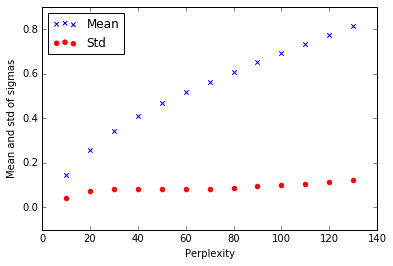

In [507]:
#Plot the means of sigmas as a function of perplexity
a=plt.scatter(range(10,131,10),mean_sigmas, color='blue', marker='x')
b=plt.scatter(range(10,131,10),std_sigmas, color='red')
plt.legend((a,b),('Mean','Std'), loc='upper left')
plt.xlabel('Perplexity')
plt.ylabel('Mean and std of sigmas')
plt.show()

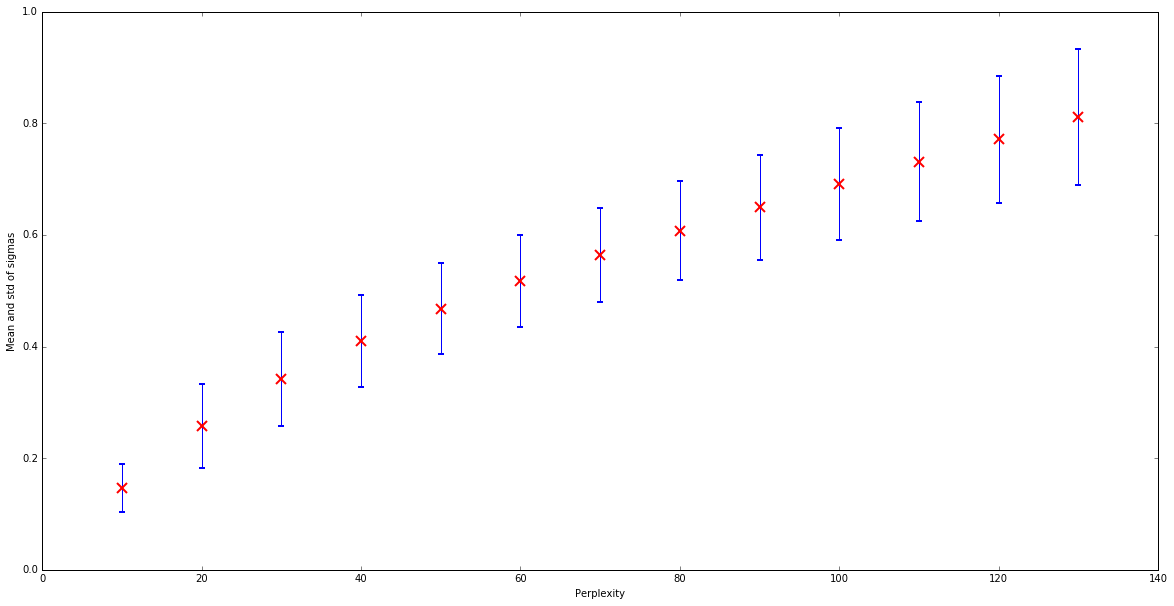

In [508]:
#Plot the means of sigmas as a function of perplexity
plt.figure(figsize=(20,10))
a=plt.errorbar(range(10,131,10),mean_sigmas, std_sigmas, linestyle="None",marker='x', mfc='green',mec='red', ms=10, mew=2)
plt.xlabel('Perplexity')
plt.ylabel('Mean and std of sigmas')
plt.ylim(0, 1.)
plt.show()

In [509]:
#Now that we have the wanted sigmas, we can compute the gaussian affinities wrt to the optimal sigmas
distances = squareform(pdist(X, 'euclidean'))
sparsity=zeros((n_K,1))
for k in range(n_K):
    A=np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        A[i]=scipy.exp(-(distances[i] ** 2 /  sigmas_opt[k][i]** 2))
    sparsity[k]=np.sum(A<epsilon)/(n_samples**2)

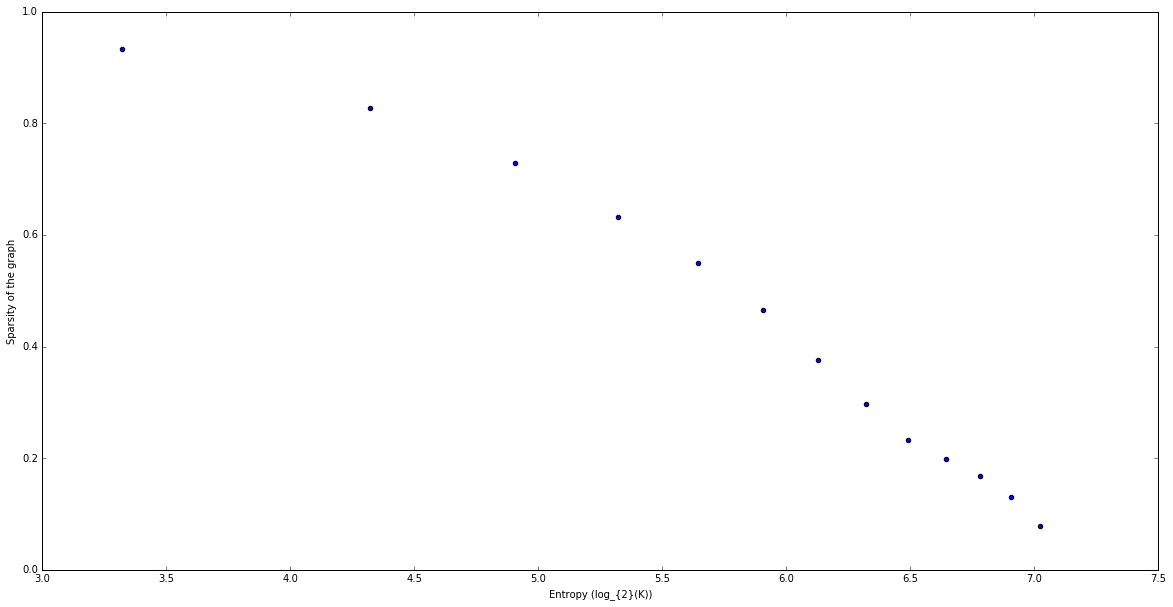

In [510]:
#Plot the sparsity of the graph as a function of entropy
log_base2_range=zeros((n_K,1))
for i in range(10,131,10):
    log_base2_range[i//10-1]=math.log(i,2)
plt.figure(figsize=(20,10))    
plt.scatter(log_base2_range,sparsity)
plt.xlabel('Entropy (log_{2}(K))')
plt.ylabel('Sparsity of the graph')
plt.show()

In [511]:
#Let's now do it for the usual knn method
A_knn=np.zeros((n_samples,n_samples))
sigma=0.5
nb_k=10
sparsity_knn=zeros((nb_k))
for k in range(1,nb_k+1):
    for i in range(n_samples):
        A_knn[i]=scipy.exp(-(distances[i] ** 2 /  sigma ** 2))
        A_knn[i][A_knn[i]<kth_smallest(n_samples-k*35,A_knn[i])]=0
    #sparsity    
    sparsity_knn[k-1]=np.sum(A_knn==0)/(n_samples**2)

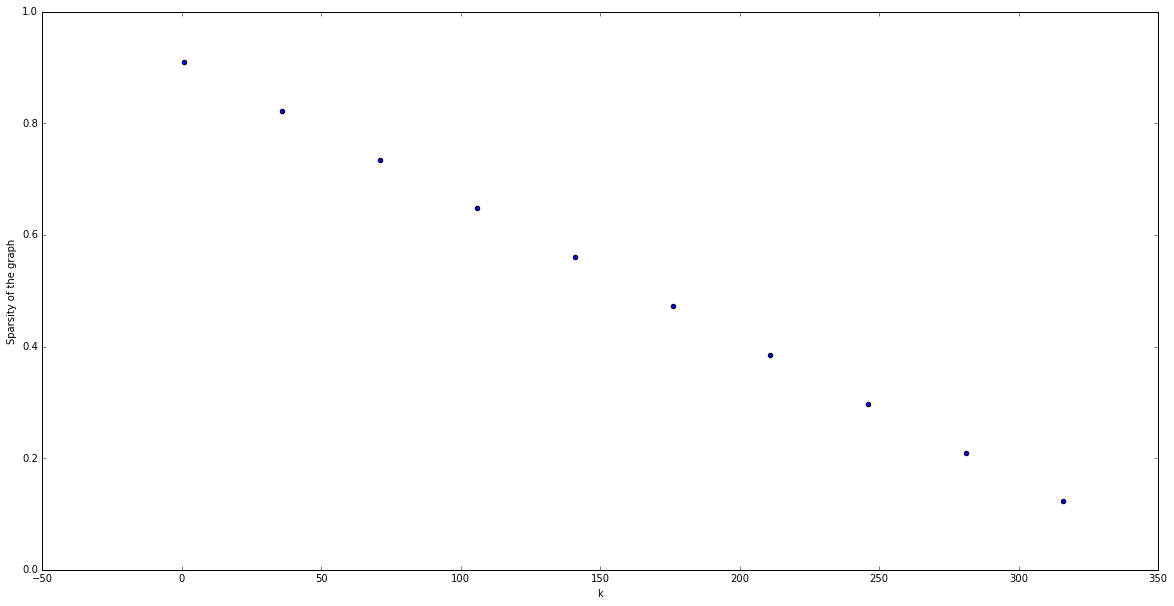

In [512]:
#Plot the sparsity of the graph as a function of entropy
plt.figure(figsize=(20,10))
plt.scatter(range(1,35*nb_k+1,35 ),sparsity_knn)
plt.xlabel('k')
plt.ylabel('Sparsity of the graph')
plt.show()

In [513]:
sparsity_knn

array([ 0.91  ,  0.8225,  0.735 ,  0.6475,  0.56  ,  0.4725,  0.385 ,
        0.2975,  0.21  ,  0.1225])

### See sparsified matrices

In [514]:
#create complete adjacency matrix, with no sparsification
distances = squareform(pdist(X, 'euclidean'))
A=np.zeros((n_samples,n_samples))
for i in range(n_samples):
    #sigma=1
    A[i]=scipy.exp(-(distances[i] ** 2 /  1** 2))
    #zeros in the diagonal
    A[i][i]=0  

In [515]:
#create sparsified adjacency matrix using entropic affinity
distances = squareform(pdist(X, 'euclidean'))
A_en=np.zeros((n_samples,n_samples))
for i in range(n_samples):
    A_en[i]=scipy.exp(-(distances[i] ** 2 /  sigmas_opt[5][i]** 2))
    #zeros in the diagonal
    A_en[i][i]=0
spars=np.sum(A_en<epsilon)/(n_samples**2)
#sparsify    
A_en[A_en<epsilon]=0
print(spars)

0.467775


In [516]:
#create sparsified matrix using KNN with euclidian metric
#A_knn = kneighbors_graph(X, 70, mode='distance', include_self=False)
#A_knn=A_knn.todense()
#spars=np.sum(A_knn==0)/(n_samples**2)
#print(spars)

In [518]:
#create sparsified adjacency matrix using entropic affinity
distances = squareform(pdist(X, 'euclidean'))
A_knn=np.zeros((n_samples,n_samples))
k=10
for i in range(n_samples):
    #sigma=1
    A_knn[i]=scipy.exp(-(distances[i] ** 2 /  1 ** 2))
    #only keep the distances of the k closest neighbors
    A_knn[i][A_knn[i]>kth_smallest(k,A_knn[i])]=0
#sparsify    
spars=np.sum(A_knn==0)/(n_samples**2)

print(spars)

0.975


In [519]:
A

array([[  0.00000000e+00,   2.35232265e-01,   2.84908125e-01, ...,
          9.99422788e-01,   8.45256681e-02,   6.58314599e-04],
       [  2.35232265e-01,   0.00000000e+00,   1.89645249e-02, ...,
          2.35924169e-01,   6.61543086e-04,   7.97722818e-05],
       [  2.84908125e-01,   1.89645249e-02,   0.00000000e+00, ...,
          2.98135977e-01,   2.73311309e-02,   1.21128152e-06],
       ..., 
       [  9.99422788e-01,   2.35924169e-01,   2.98135977e-01, ...,
          0.00000000e+00,   8.14065542e-02,   5.77750768e-04],
       [  8.45256681e-02,   6.61543086e-04,   2.73311309e-02, ...,
          8.14065542e-02,   0.00000000e+00,   4.87182102e-03],
       [  6.58314599e-04,   7.97722818e-05,   1.21128152e-06, ...,
          5.77750768e-04,   4.87182102e-03,   0.00000000e+00]])

In [520]:
A_en

array([[  0.00000000e+00,   6.94307932e-04,   1.81844906e-03, ...,
          9.97102678e-01,   4.05268286e-06,   0.00000000e+00],
       [  2.29022129e-02,   0.00000000e+00,   3.20752365e-05, ...,
          2.30784199e-02,   0.00000000e+00,   0.00000000e+00],
       [  2.07890848e-02,   4.87163854e-06,   0.00000000e+00, ...,
          2.39131494e-02,   1.50415343e-05,   0.00000000e+00],
       ..., 
       [  9.97106989e-01,   7.12293804e-04,   2.30507133e-03, ...,
          0.00000000e+00,   3.41853461e-06,   0.00000000e+00],
       [  1.84644302e-06,   0.00000000e+00,   0.00000000e+00, ...,
          1.51035902e-06,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   5.36615947e-06,   0.00000000e+00]])

In [521]:
A_knn

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   6.58314599e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.21128152e-06],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   5.77750768e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

### Pour le même taux de sparsification, comparer les propriétés spectrales des graphes

In [522]:
L_en=scipy.sparse.csgraph.laplacian(A_en, normed=True)
L_knn=scipy.sparse.csgraph.laplacian(A_knn, normed=True)

In [523]:
eigen_values=scipy.linalg.eigh(L_en,eigvals_only=True)
eigen_values_knn=scipy.linalg.eigh(L_knn,eigvals_only=True)

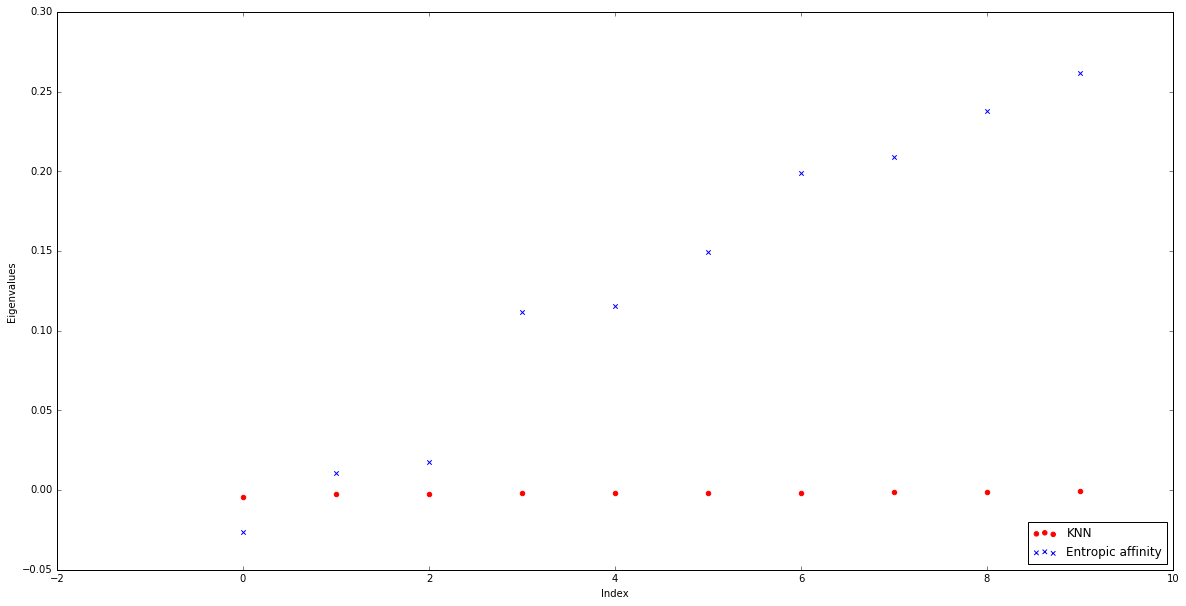

In [524]:
plt.figure(figsize=(20,10))
a=plt.scatter(range(10),eigen_values_knn[:10],color='red')
b=plt.scatter(range(10),eigen_values[:10],color='blue', marker='x')
plt.legend((a,b),('KNN','Entropic affinity'), loc='lower right')
plt.xlabel('Index')
plt.ylabel('Eigenvalues')
plt.show()

### Comparaison des propriétés spectrales selon la sparsification
#### Première méthode : similarités entre les spectres

In [525]:
#Compute similarities for different sparsities
nb_similarities=11
gt_knn=zeros((nb_similarities))
gt_en=zeros((nb_similarities))
spars_knn=zeros((nb_similarities))
spars_en=zeros((nb_similarities))
for it in range(nb_similarities):
    
    #NO SPARSIFICATION
    
    
    #create complete adjacency matrix, with no sparsification
    distances = squareform(pdist(X, 'euclidean'))
    A=np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        #sigma=1
        A[i]=scipy.exp(-(distances[i] ** 2 /  0.8** 2))
        #zeros in the diagonal
        A[i][i]=0  
        
        
        
    #ENTROPIC AFFINITY
    

    #create sparsified adjacency matrix using entropic affinity
    distances = squareform(pdist(X, 'euclidean'))
    A_en=np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        A_en[i]=scipy.exp(-(distances[i] ** 2 /  sigmas_opt[it][i]** 2))
        #zeros in the diagonal
        A_en[i][i]=0
    spars_en[it]=np.sum(A_en<epsilon)/(n_samples**2)
    #sparsify    
    A_en[A_en<epsilon]=0
    print(spars_en[it])
    
    
    
    #KNN
    
    
    #create sparsified adjacency matrix using entropic affinity
    distances = squareform(pdist(X, 'euclidean'))
    A_knn=np.zeros((n_samples,n_samples))
    k=35*(it+1)
    for i in range(n_samples):
        #sigma=1
        A_knn[i]=scipy.exp(-(distances[i] ** 2 /  0.8 ** 2))
        #only keep the distances of the k closest neighbors
        A_knn[i][A_knn[i]<kth_smallest(n_samples-k,A_knn[i])]=0
    #sparsify    
    spars_knn[it]=np.sum(A_knn==0)/(n_samples**2)
    print(spars_knn[it])
    
    #COMPUTE SIMILARITIES
    
    
    #Compute eigen values
    eigen_values=scipy.linalg.eigh(A,eigvals_only=True)
    eigen_values_en=scipy.linalg.eigh(A_en,eigvals_only=True)
    eigen_values_knn=scipy.linalg.eigh(A_knn,eigvals_only=True)
    #normalize the eigenvalues
    normed=eigen_values/sum(abs(eigen_values))
    normed_en=eigen_values_en/sum(abs(eigen_values_en))
    normed_knn=eigen_values_knn/sum(abs(eigen_values_knn))
    #compute similarity between spectra
    gt_en[it]=np.dot(normed, normed_en)
    gt_knn[it]=np.dot(normed, normed_knn)

0.9366375
0.91
0.82963125
0.8225
0.73120625
0.735
0.6355875
0.6475
0.5524
0.56
0.467775
0.4725
0.377775
0.385
0.3002375
0.2975
0.23546875
0.21
0.2007625
0.1225
0.1702
0.035


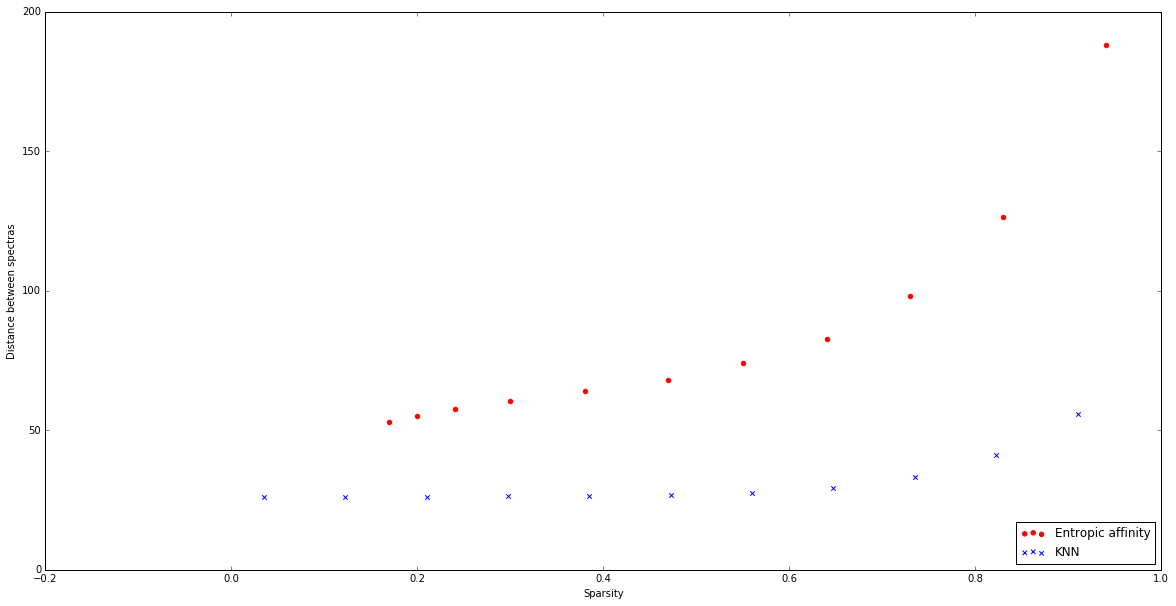

In [526]:
#Plot results

plt.figure(figsize=(20,10))
r=range(nb_similarities)
spars_en=numpy.around(spars_en, decimals=2)
a=plt.scatter(spars_en,1/gt_en,color='red')
b=plt.scatter(spars_knn,1/gt_knn,color='blue', marker='x')
#for i, txt in enumerate(spars_en):
#    plt.annotate(txt, (r[i],gt_en[i]))
#for i, txt in enumerate(spars_knn):
#    plt.annotate(txt, (r[i],gt_knn[i]))
plt.legend((a,b),('Entropic affinity','KNN'), loc='lower right')
plt.xlabel('Sparsity')
plt.ylabel('Distance between spectras')
plt.show()

#### Deuxième méthode : distance entre les k-top eigenvectors

In [527]:
#Compute similarities for different sparsities
nb_similarities=11
spars_knn=zeros((nb_similarities))
spars_en=zeros((nb_similarities))

distance_gt_en=zeros((nb_similarities))
distance_gt_knn=zeros((nb_similarities))

topk=20
#d=zeros((topk))
d_en=zeros((topk))
d_knn=zeros((topk))
for it in range(nb_similarities):
    
    #NO SPARSIFICATION
    
    
    #create complete adjacency matrix, with no sparsification
    distances = squareform(pdist(X, 'euclidean'))
    A=np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        #sigma=1
        A[i]=scipy.exp(-(distances[i] ** 2 /  0.8** 2))
        #zeros in the diagonal
        A[i][i]=0 
        
    """#Compute Laplacian and get eigenvectors    
    L=scipy.sparse.csgraph.laplacian(A, normed=False)
    spectrum=scipy.linalg.eigh(L)
    #print(spectrum)
    aux=0
    for j in range(len(spectrum[1])-topk,len(spectrum[1])):
        v=spectrum[1][j]
        d[aux]=v.dot(L.dot(v))
        aux+=1"""

        
        
        
    #ENTROPIC AFFINITY
    

    #create sparsified adjacency matrix using entropic affinity
    distances = squareform(pdist(X, 'euclidean'))
    A_en=np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        A_en[i]=scipy.exp(-(distances[i] ** 2 /  sigmas_opt[it][i]** 2))
        #zeros in the diagonal
        A_en[i][i]=0
    spars_en[it]=np.sum(A_en<epsilon)/(n_samples**2)
    #sparsify    
    A_en[A_en<epsilon]=0
    print(spars_en[it])
    
    """#Compute Laplacian and get eigenvectors    
    L_en=scipy.sparse.csgraph.laplacian(A_en, normed=False)
    spectrum_en=scipy.linalg.eigh(L_en)
    #print(spars_en)
    aux=0
    for j in range(len(spectrum_en[1])-topk,len(spectrum_en[1])):
        v_en=spectrum_en[1][j]
        d_en[aux]=v_en.dot(L_en.dot(v_en))
        aux+=1"""
        
        
    
    #KNN
    
    
    #create sparsified adjacency matrix using entropic affinity
    distances = squareform(pdist(X, 'euclidean'))
    A_knn=np.zeros((n_samples,n_samples))
    k=35*(it+1)
    for i in range(n_samples):
        #sigma=1
        A_knn[i]=scipy.exp(-(distances[i] ** 2 /  0.8 ** 2))
        #only keep the distances of the k closest neighbors
        A_knn[i][A_knn[i]<kth_smallest(n_samples-k,A_knn[i])]=0
    #sparsify    
    spars_knn[it]=np.sum(A_knn==0)/(n_samples**2)
    print(spars_knn[it])
    
    """#Compute Laplacian and get eigenvectors    
    L_knn=scipy.sparse.csgraph.laplacian(A_knn, normed=False)
    spectrum_knn=scipy.linalg.eigh(L_knn)
    aux=0
    for j in range(len(spectrum_knn[1])-topk,len(spectrum_knn[1])):
        v_knn=spectrum_knn[1][j]
        d_knn[aux]=v_knn.dot(L_knn.dot(v_knn))
        aux+=1"""
        
        
    #Compute Laplacian and get eigenvectors    
    L=scipy.sparse.csgraph.laplacian(A, normed=False)
    L_en=scipy.sparse.csgraph.laplacian(A_en, normed=False)
    L_knn=scipy.sparse.csgraph.laplacian(A_knn, normed=False)

    spectrum=scipy.linalg.eigh(L)
    #print(spectrum)
    aux=0
    for j in range(len(spectrum[1])-topk,len(spectrum[1])):
        v=spectrum[1][j]
        d_en[aux]=v.dot(L.dot(v))-v.dot(L_en.dot(v))
        d_knn[aux]=v.dot(L.dot(v))-v.dot(L_knn.dot(v))
        aux+=1
    
    
    
    #COMPUTE DISTANCES
    
    distance_gt_en[it]=sum((d_en)**2)
    distance_gt_knn[it]=sum((d_knn)**2)

0.9366375
0.91
0.82963125
0.8225
0.73120625
0.735
0.6355875
0.6475
0.5524
0.56
0.467775
0.4725
0.377775
0.385
0.3002375
0.2975
0.23546875
0.21
0.2007625
0.1225
0.1702
0.035


In [528]:
distance_gt_knn

array([  1.03114375e+04,   2.32976943e+03,   4.93380882e+02,
         9.35040134e+01,   1.84639229e+01,   3.86195392e+00,
         6.76192946e-01,   5.43309728e-02,   6.74689703e-04,
         1.70372826e-05,   1.47794612e-07])

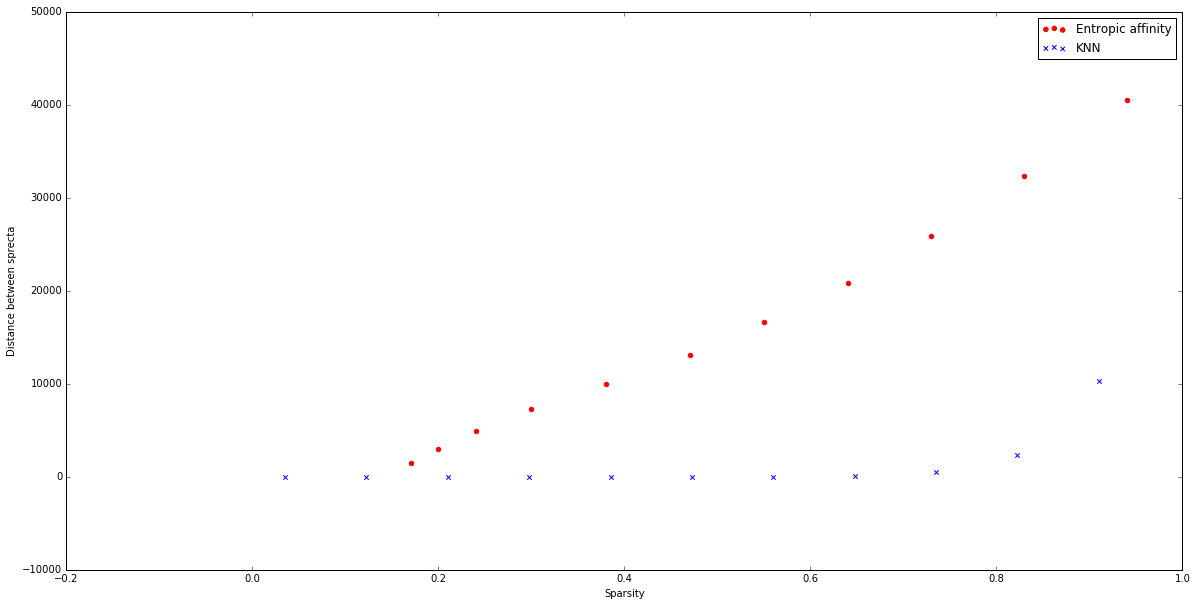

In [529]:
#Plot results

plt.figure(figsize=(20,10))
r=range(nb_similarities)
spars_en=numpy.around(spars_en, decimals=2)
a=plt.scatter(spars_en,distance_gt_en,color='red')
b=plt.scatter(spars_knn,distance_gt_knn,color='blue', marker='x')
#for i, txt in enumerate(spars_en):
#    plt.annotate(txt, (r[i],distance_gt_en[i]))
#for i, txt in enumerate(spars_knn):
#    plt.annotate(txt, (r[i],distance_gt_knn[i]))
plt.legend((a,b),('Entropic affinity','KNN'), loc='upper right')
plt.xlabel('Sparsity')
plt.ylabel('Distance between sprecta')
plt.show()

In [530]:
distance_gt_knn

array([  1.03114375e+04,   2.32976943e+03,   4.93380882e+02,
         9.35040134e+01,   1.84639229e+01,   3.86195392e+00,
         6.76192946e-01,   5.43309728e-02,   6.74689703e-04,
         1.70372826e-05,   1.47794612e-07])

# Spectal Clustering tests

In [531]:
spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack', affinity="precomputed")
spectral.fit(A)
accuracy_score(y,spectral.labels_)

0.495

In [532]:
#Compute similarities for different sparsities
nb_similarities=11
spars_knn=zeros((nb_similarities))
spars_en=zeros((nb_similarities))

acc_en=zeros((nb_similarities))
acc_knn=zeros((nb_similarities))

spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack', affinity="precomputed")


for it in range(nb_similarities):
    
    #NO SPARSIFICATION
    #create complete adjacency matrix, with no sparsification
    distances = squareform(pdist(X, 'euclidean'))
    A=np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        #sigma=1
        A[i]=scipy.exp(-(distances[i] ** 2 /  0.3** 2))
        #zeros in the diagonal
        A[i][i]=0 
    
    spectral.fit(A)
    acc=accuracy_score(y,spectral.labels_)
    if acc<0.5:
        acc=1-acc
    print(acc,'complete graph accuracy')
        


        
        
        
    #ENTROPIC AFFINITY
    

    #create sparsified adjacency matrix using entropic affinity
    distances = squareform(pdist(X, 'euclidean'))
    A_en=np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        A_en[i]=scipy.exp(-(distances[i] ** 2 /  sigmas_opt[it][i]** 1.7))
        #zeros in the diagonal
        A_en[i][i]=0
    spars_en[it]=np.sum(A_en<epsilon)/(n_samples**2)
    #sparsify    
    A_en[A_en<epsilon]=0
    #print(spars_en[it])
    
    spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack', affinity="precomputed")
    spectral.fit(A_en)
    acc_en[it]=accuracy_score(y,spectral.labels_)
    if acc_en[it]<0.5:
        acc_en[it]=1-acc_en[it]
    print(acc_en[it], 'accuracy for EA')
    

        
        
    
    #KNN
    
    
    #create sparsified adjacency matrix using knn
    distances = squareform(pdist(X, 'euclidean'))
    A_knn=np.zeros((n_samples,n_samples))
    k=35*(it+1)
    for i in range(n_samples):
        #sigma=1
        A_knn[i]=scipy.exp(-(distances[i] ** 2 /  0.3 ** 2))
        #only keep the distances of the k closest neighbors
        A_knn[i][A_knn[i]<kth_smallest(n_samples-k,A_knn[i])]=0
    #sparsify    
    spars_knn[it]=np.sum(A_knn==0)/(n_samples**2)
    #print(spars_knn[it])
    
    spectral = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack', affinity="precomputed")
    spectral.fit(A_knn)
    acc_knn[it]=accuracy_score(y,spectral.labels_)
    if acc_knn[it]<0.5:
        acc_knn[it]=1-acc_knn[it]
    print(acc_knn[it], 'accuracy for KNN')


1.0 complete graph accuracy
1.0 accuracy for EA


/Users/Syzygy/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:629: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


1.0 accuracy for KNN
1.0 complete graph accuracy
0.7775 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.51 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.51 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.5075 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.5075 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.5075 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.5075 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.5075 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.505 accuracy for EA
1.0 accuracy for KNN
1.0 complete graph accuracy
0.5025 accuracy for EA
1.0 accuracy for KNN


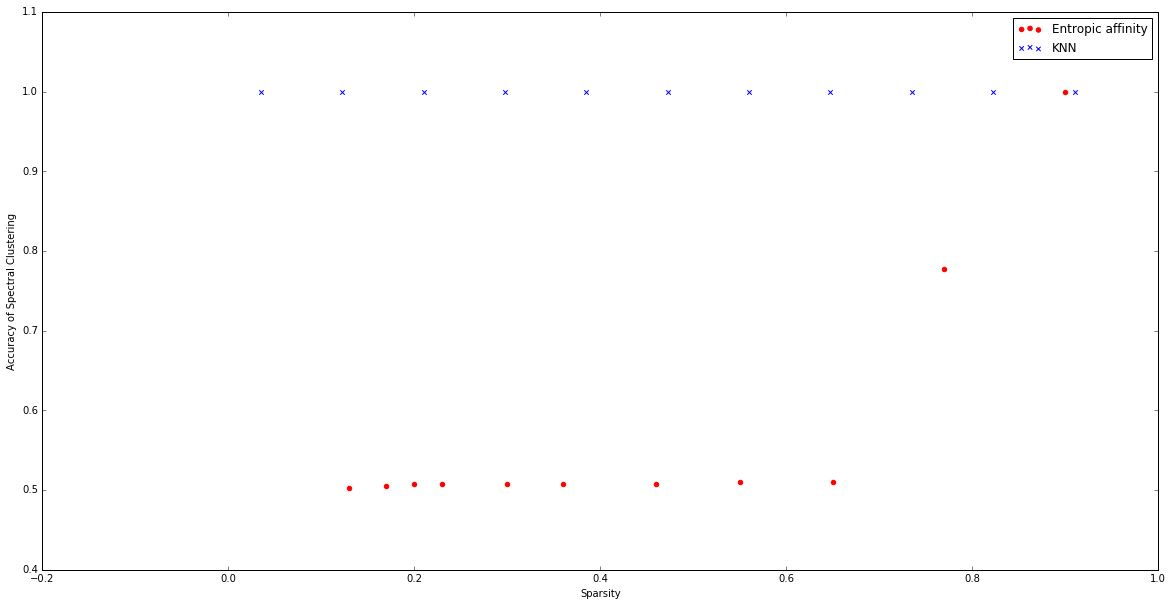

In [533]:
#Plot results

plt.figure(figsize=(20,10))
r=range(nb_similarities)
spars_en=numpy.around(spars_en, decimals=2)
a=plt.scatter(spars_en,acc_en,color='red')
b=plt.scatter(spars_knn,acc_knn,color='blue', marker='x')
#for i, txt in enumerate(spars_en):
#    plt.annotate(txt, (r[i],distance_gt_en[i]))
#for i, txt in enumerate(spars_knn):
#    plt.annotate(txt, (r[i],distance_gt_knn[i]))
plt.legend((a,b),('Entropic affinity','KNN'), loc='upper right')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy of Spectral Clustering')
plt.show()

In [538]:
#create sparsified adjacency matrix using entropic affinity
distances = squareform(pdist(X, 'euclidean'))
A_en=np.zeros((n_samples,n_samples))
for i in range(n_samples):
    A_en[i]=scipy.exp(-(distances[i] ** 2 /  sigmas_opt[0][i]** 2))
    #zeros in the diagonal
    A_en[i][i]=0
print(np.sum(A_en<epsilon)/(n_samples**2))
#sparsify    
A_en[A_en<epsilon]=0
#print(spars_en[it])
print(np.sum(A_en==0)/(n_samples**2))    

#create sparsified adjacency matrix using knn
it=0
distances = squareform(pdist(X, 'euclidean'))
A_knn=np.zeros((n_samples,n_samples))
k=25*(it+1)
for i in range(n_samples):
    #sigma=1
    A_knn[i]=scipy.exp(-(distances[i] ** 2 /  0.3 ** 2))
    #only keep the distances of the k closest neighbors
    A_knn[i][A_knn[i]<kth_smallest(n_samples-k,A_knn[i])]=0
#sparsify    
print(np.sum(A_knn==0)/(n_samples**2))

0.9366375
0.9366375
0.935


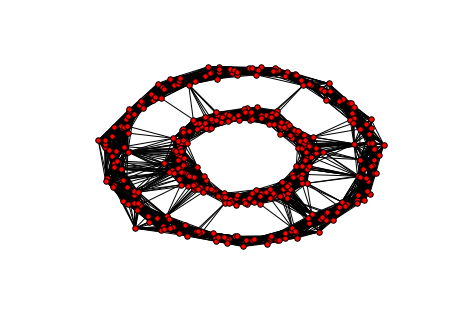

In [539]:
#creation of the graph

connect_en=[]
for i in range(len(A_en)):
    for j in range(len(A_en)):
        if A_en[i,j]!=0:
            connect_en.append(tuple([i,j]))
            

graph = nx.Graph()
#adding nodes/connections in the graph
for node in range(len(X)):
    graph.add_node(node)
graph.add_edges_from(connect_en)

#plot of the nodes using the (x,y) pairs as coordinates
nx.draw(graph, [(x,y) for x,y in X], node_size=30)

10400
0.07116541353383458


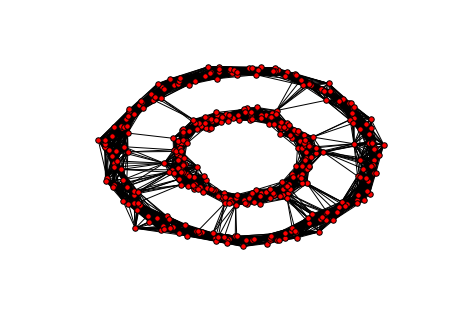

In [540]:
#creation of the graph

lol=0
connect_knn=[]
for i in range(len(A_knn)):
    for j in range(len(A_knn)):
        if A_knn[i,j]!=0:
            connect_knn.append(tuple([i,j]))
            lol=lol+1
print(lol)
            

graph = nx.Graph()
#adding nodes/connections in the graph
for node in range(len(X)):
    graph.add_node(node)
graph.add_edges_from(connect_knn)
print(nx.density(graph))

#plot of the nodes using the (x,y) pairs as coordinates
nx.draw(graph, [(x,y) for x,y in X], node_size=30)

In [461]:
len(connect_en)

19741

In [455]:
len(connect_knn)

14400